# Analysis Routine for FCC-ee Backgrounds

* [1. Machine Parameters](#MchnPrm)
* [2. Global Geometry](#GlbGeom)
* [3. Data Input Level](#Data-Input)
* [3.1 Specify Lattice](#LtcSpSplt)
* [4. Data Visualization](#DtVsl)
* [4.1 Default Photon Events - Direct Photons](#DvltPhtEvtsDrtc)
* [4.2 Energy Distribution Secondaries](#EnrgSpctr) 
* [4.2.1 Global](#EnrgSpctrGlb)
* [4.2.2 Dipoles](#EnrgSpctrDpls)
* [4.2.3 Quadrupoles](#EnrgSpctrQdrpls)
* [4.4 Energy Distribution Secondaries](#EnrgDstrScnd)
* [4.2 Hits (Element specific)](#HtsElmt)


In [30]:
%reset
import pandas as pd
import matplotlib.pyplot as plt 
from os import path
from scipy.constants import k, hbar, alpha, pi, speed_of_light, elementary_charge, m_e, physical_constants, N_A
import sys

%cd ~/Codes/Python/FCC-ee/source/
from TfsTables import TfsReader
from SynchrotronRadiation import SynchrotronRadiation
from Input import DataReader, readParams
from OpticsSelectTools import DataSelection 
from Tools import rel_s, calcAper, sbplSetUp
from PhotoInteract import Processes
from DF_Tools import OutputToDF
import Plot as pltdat   
from VisualSpecs import myColors as colors

from IPython.core.display import display, HTML
# temporarily disable the SetCopies warning:
pd.options.mode.chained_assignment = None

%reload_ext autoreload

%aimport Input, OpticsSelectTools, Plot

%autoreload 1
# %matplotlib inline

E0 = 182.5
if E0 == 45.6:
    Nbun = 16640; Np = 1.7e11
    sigZ = 3.5e-3
    epsX = .27e-9; epsY = 1e-12
elif E0 == 182.5:
    Nbun = 48; Np = 2.3e11
    sigZ = 1.97e-3
    epsX = 1.46e-9; epsY = 2.9e-12
Lrnt = E0/511e-6
brho = 10*E0/2.9979
particle = "positron"

print("---- Beam Parameters b1 ---- \n", " Beam energy =", E0, 'with', Nbun, 'bunches/beam with population of', Np, 'particles \n', 'bunch length (SR) =', sigZ, "m",
      "\n emittance x,y =", epsX, epsY, "m",
      "\n Brho =", brho, "\n Lorentz gamma =", Lrnt, 
     "\n ----------------------------- " )

home = path.expanduser("~")
plotpath = "/tmp/"
display(HTML("<style>.container { width:100% !important; }</style>"))

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
/home/mlueckhof/Codes/Python/FCC-ee/source
---- Beam Parameters b1 ---- 
  Beam energy = 182.5 with 48 bunches/beam with population of 230000000000.0 particles 
 bunch length (SR) = 0.00197 m 
 emittance x,y = 1.46e-09 2.9e-12 m 
 Brho = 608.7594649588045 
 Lorentz gamma = 357142.85714285716 
 ----------------------------- 


## 1. FCC-ee Parameters<a class="anchor" id="MchnPrm"></a>
The following is just a small function that reads FCCee beam parameters from the xlsx file where they can be easily updated. This tool allows to display and save all or parts of the table as csv. The csv format can then be used within LaTeX if a parameter table is needed.

In [3]:
file = home + '/PhD/Notes/IRDesign/data/FCCeeParamList.xlsx'
FCCeeParams = readParams(file)
FCCeeParams

,parameter,Z,W,H (ZH),ttbar,ttbar.1
0,beam energy [GeV],46,80,120,175,1.8e+02
1,arc cell optics,60/60,90/90,90/90,90/90,90/90
2,momentum compaction [E-5],1.5,0.73,0.73,0.73,0.73
3,horizontal emittance [nm],0.27,0.28,0.63,1.3,1.4
4,vertical emittance [pm],1,1,1.3,2.7,2.7
5,horizontal beta* [m],0.15,0.2,0.3,1,1
6,vertical beta* [mm],0.8,1,1,2,2
7,length interaction area [mm],0.42,0.5,0.9,1.9,2
8,"tunes, half-ring (x,y,s)","(0.569,0.61,0.0125)","(0.577,0.61,0.0115)","(0.565,0.60,0.0180)","(0.553,0.59,0.0343)","(0.553, 0.59, 0.0350)"
9,longitudinal damping time [ms],414,77,23,7.5,6.6


## 3. Data Input Level<a class="anchor" id="Data-Input"></a>
Data input by using methods from class Input

In [26]:
test = SynchrotronRadiation( ntuples = ['/data/photon_background_flat2.root','/data/photon_background_gauss1.root','/data/photon_background_pencil0.root'], 
                             plotpath = plotpath, verbose = 0 )
pencil = SynchrotronRadiation( ntuples=['/data/photon_background_pencil0.root'] )
ring = SynchrotronRadiation( ntuples=['/data/photon_background_ring-1.root'], verbose = 3 )
gauss = SynchrotronRadiation( ntuples=['/data/photon_background_gauss1.root'], verbose = 3 )
# # old method
# #
# Storage = DataReader(filepath = ['/tmp/'], verbose = 1)

# DFseco_def = Storage.readG4out(read = 'secondaries', datType = 'default', verbose = 2)
# # DFprim_def = Storage.readG4out(read = 'primaries', datType = 'default', verbose = 2)
# # DFseco_col = Storage.readG4out(read = 'secondaries', datType = 'collimation', verbose = 2)

### 3.1 Specify Lattice and Split <a class="anchor" id="LtcSpSplt"></a>
This section allows to choose certain optics version for the processing further below. Also, beam sizes and aperture limits (collimators) can be selected. **Important: the selection needs to be done at the end as it alters the DF.**

In [7]:
Selection = DataSelection(DFseco_def, verbose = 1)
# Selection2 = DataSelection(DFseco_col, verbose = 0)

In [8]:
def_opt = Selection.opticsSelection(optics = [])  
def_opt = Selection.splitNames() 
def_opt = Selection.elmSelection(elements = [])
pltFCCdef = Selection.sliceFrame( beam = ['pencil'], size = [] ) 

# col_opt = Selection2.opticsSelection(optics = [])  
# col_opt = Selection2.splitNames() 
# col_opt = Selection2.elmSelection(elements = [])
# pltFCCcol = Selection2.sliceFrame( beam = ['pencil'], size = [], aperture = [] )

Optics list is empty, inferring from DF: ['fcc_ee']
-*-*-*-*-*-*-*-*-*-*-*-*-*- 
 Following frame(s) selected:
-- fcc_ee
Found no collimator frame - analysing default data 
 -----------------------------
-*-*-*-*-*-*-*-*-*-*-*-*-*- 
 Selected following data frame: def_secondaries
maximum number of parts in Name: 3
selected all beam types and sizes!


## 4. Data Visualization Level<a class="anchor" id="DtVsl"></a>

### 4.1 Default Photon Events - Direct Photons<a class="anchor" id="DvltPhtEvtsDrtc"></a>
Selecting events via the keys `initStep` and `Creator` allows to choose only those photons created from synchrotron radiation. This way, the 'origin' plot really shows where SR photons are generated upstream of the IP.
Hence, the plot type `hit` would show all photons **created directly by synchrotron radiation** which then impact on the beam pipe. It ignores hits caused by sub-processes as photo-effect, compton scattering, rayleigh scattering, etc.

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
collimators fully open.
setting beamType to pencil 
 setting aperture to [] 
 found size 0
data types: beamType = <class 'str'> aperture = <class 'list'> size = <class 'int'>
plotting done, deleted DF.
saved plot as /tmp/ SR_hits_beamshape.pdf
CPU times: user 978 ms, sys: 29.3 ms, total: 1.01 s
Wall time: 1.01 s


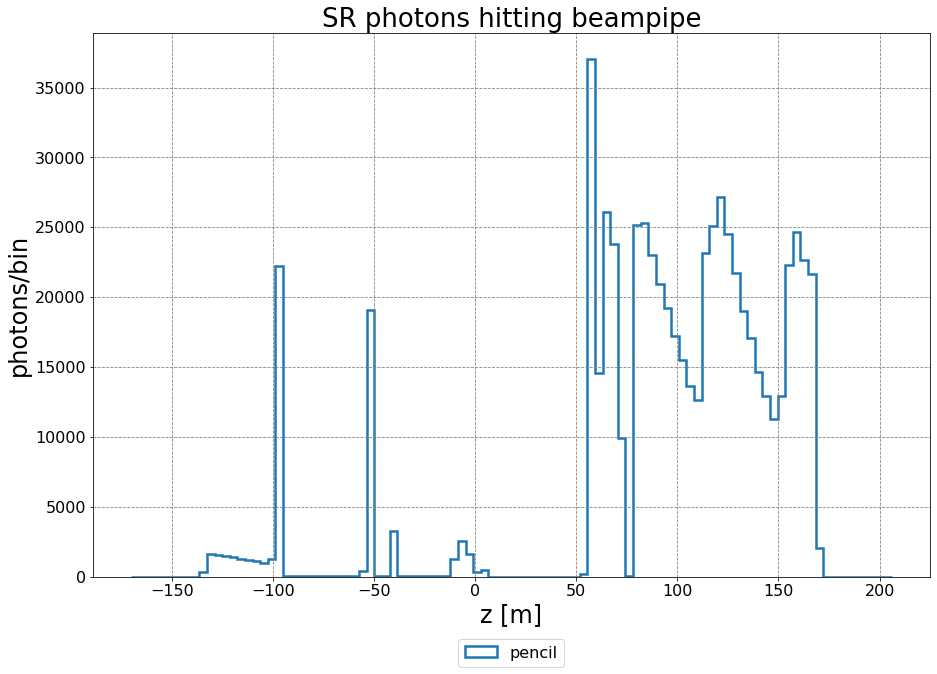

In [4]:
# test.defaultSRData( zlim = [], Type='origin', nBin = 100, save = 0 )

# profiling: function takes about 31s for three files (5000prim). 98% spend on readData() with pandas DF
#
%load_ext line_profiler
# %lprun -f test.defaultSRData test.defaultSRData( zlim = [-10,10], Type='origin', nBin = 100, save = 0 )
%time pencil.defaultSRData( zlim = [], Type='hit', nBin = 100, save = 1, legCol=4 )

# old routine 
# pltdat.plot_defaultData( pltFCCdef, plotpath, beam = ['pencil'], Type = 'origin', zlim = [], nBin = 100, save = 0 )
# pltdat.plot_defaultData( pltFCCdef, plotpath, beam = 'all', Type = 'hit', zlim = [], nBin = 100, save = 0 )

### 4.2 Energy Distribution of Secondaries<a class="anchor" id="EnrgSpctr"></a>

#### 4.2.1 Global<a class="anchor" id="EnrgSpctrGlb"></a>

collimators fully open.
setting beamType to pencil 
 setting aperture to [] 
 found size 0
data types: beamType = <class 'str'> aperture = <class 'list'> size = <class 'int'>
plotting done, deleted DF.
saved plot as /tmp/ SR_energy_spectrumgeneral.pdf
CPU times: user 1.77 s, sys: 110 ms, total: 1.88 s
Wall time: 1.7 s


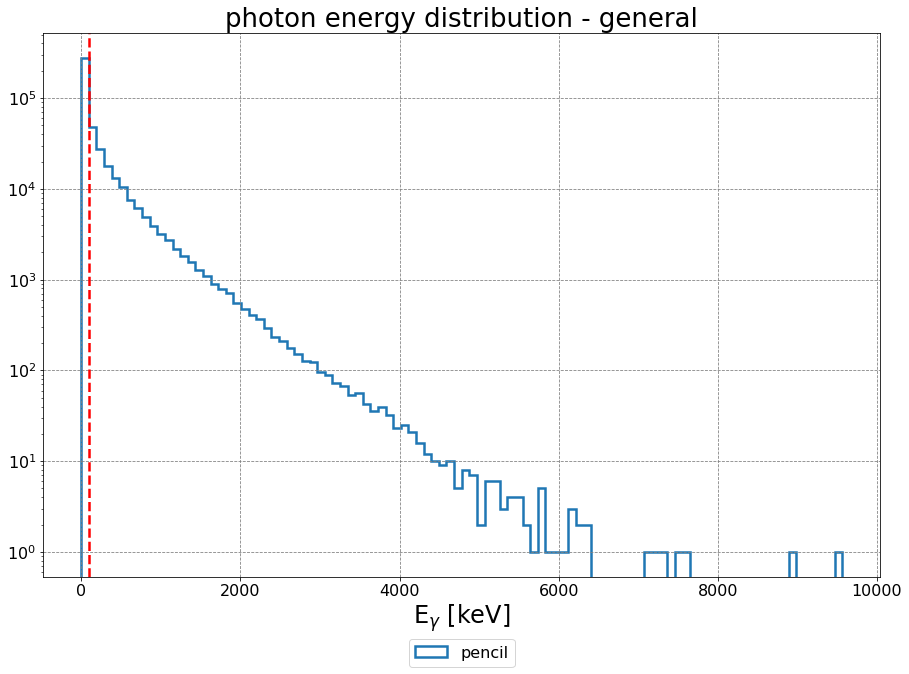

In [13]:
# %lprun -f test.energySpectrum test.energySpectrum( )
%time pencil.energySpectrum( save = 1, legCol=4 )

# old routine
# pltdat.plot_Energy(pltFCCdef, plotpath, Type = 'spectrum', nBin = 100, save = 0, verbose = 0, legCol = 3)  
# pltdat.plot_Energy(pltFCCcol, plotpath, Type = 'spectrum', nBin = 100, save = 0, verbose = 0 )  

#### 4.2.2 Dipoles<a class="anchor" id="EnrgSpctrDpls"></a>
Each dipole has a characteristic energy spectrum, depending on bending radius $\rho$ and particle energy. In order to describe the role of single magnets wrt. their possible contribution to photon backgrounds, it's useful to look on single energy spectra and compare them with each other. 

**For the thesis**
* Especially compare the innermost bends (aka last two $\leq100$ keV) with the magnets further upstream. Also a comparison between bends and final focus quads/solenoid can be useful (see below)
* The spectra above give a nice baseline for a discussion on magnet types in FCC-ee to take into account

collimators fully open.
setting beamType to pencil 
 setting aperture to [] 
 found size 0
data types: beamType = <class 'str'> aperture = <class 'list'> size = <class 'int'>
plotting done, deleted DF.
saved plot as /tmp/ SR_energy_spectrumDiploes.pdf
CPU times: user 9.1 s, sys: 290 ms, total: 9.39 s
Wall time: 9.25 s


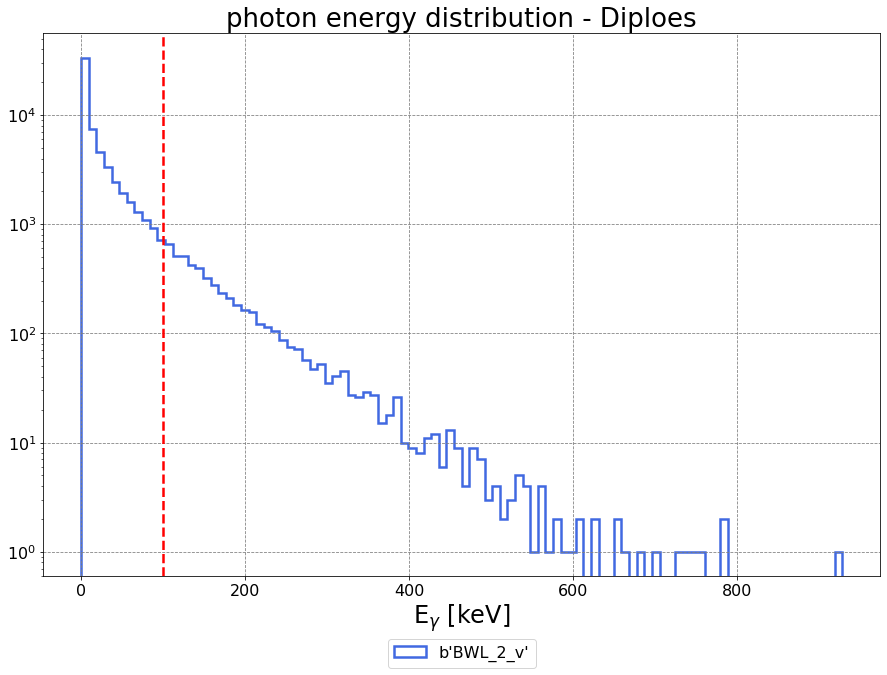

In [6]:
# %lprun -f test.energySpectrum test.energySpectrum( Type='Dipoles', magnets=[b'BWL_2_v',b'BC1_1_v'] )
# %time test.energySpectrum( Type='Dipoles', magnets=[b'BWL_2_v',b'BC1_1_v'] )
%time pencil.energySpectrum( Type = 'Diploes', magnets = [b'BWL_2_v'], save = 1 )


#### 4.2.3 Quadrupoles<a class="anchor" id="EnrgSpctrQdrpls"></a>
Look into the energy of photons explicitly radiated from quadrupoles. The final focus quads (FFQs) need special attention since they're among the strongest magnets and close to the IP. Slight orbit deviations, beam tailes, etc. might lead to synchrotron radiation that is not directed straight out of the IR. 
* Compare FFQs with upstream bends. 
* Look into radiation from FFQs hitting the pipe some 10 m downstream of the IP (vacuum issue)

collimators fully open.
setting beamType to pencil 
 setting aperture to [] 
 found size 0
data types: beamType = <class 'str'> aperture = <class 'list'> size = <class 'int'>
plotting done, deleted DF.
saved plot as /tmp/ SR_energy_spectrumSolenoid.pdf
CPU times: user 10.3 s, sys: 322 ms, total: 10.6 s
Wall time: 10.5 s


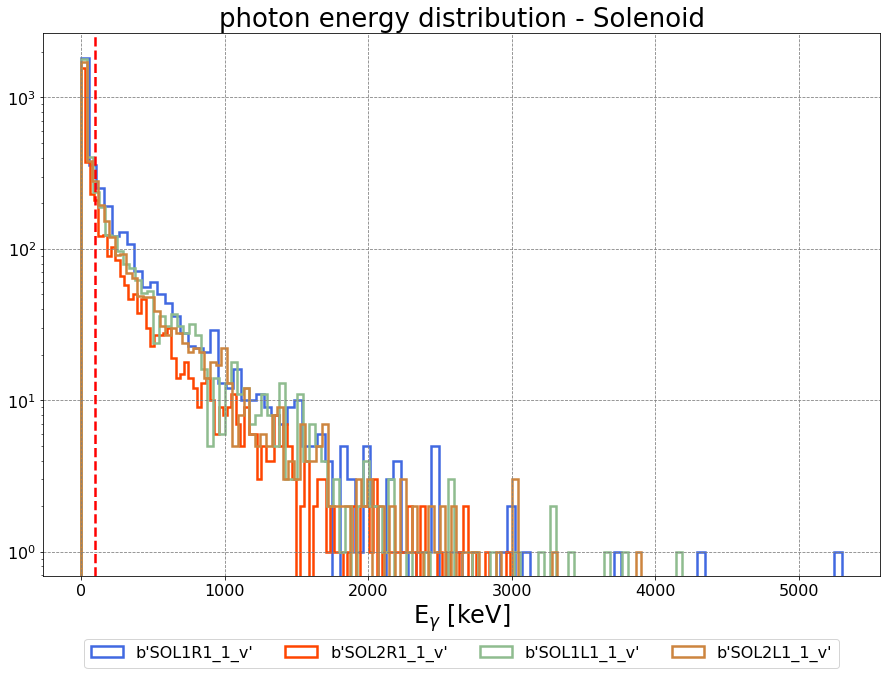

In [12]:
# %lprun -f test.energySpectrum test.energySpectrum( Type = 'Quads', magnets = [b'QC1R3_1_v',b'QC1R2_1_v'])
%time pencil.energySpectrum( Type = 'Solenoid', magnets = [b'SOL1R1_1_v',b'SOL2R1_1_v',b'SOL1L1_1_v',b'SOL2L1_1_v'], save = 1, legCol = 4 )

#### Photon Background - inner Interaction Region and Central Chamber
Below follows a quick investigation of the photons that impact on the beam pipe wall within +/- 10 m around the interaction point. Comparison between different initial transverse particle distributions is interesting. It shows, that a majority of photons looses in good approximation all of their energy.
However, the remaining photons, which are not stopped are distributed around 100 keV and therefore not at all negligible. 

collimators fully open.
setting beamType to pencil 
 setting aperture to [] 
 found size 0
data types: beamType = <class 'str'> aperture = <class 'list'> size = <class 'int'>
plotting done, deleted DF.
saved plot as /tmp/ SR_energy_spectrumhit.pdf
CPU times: user 1.86 s, sys: 125 ms, total: 1.99 s
Wall time: 1.81 s


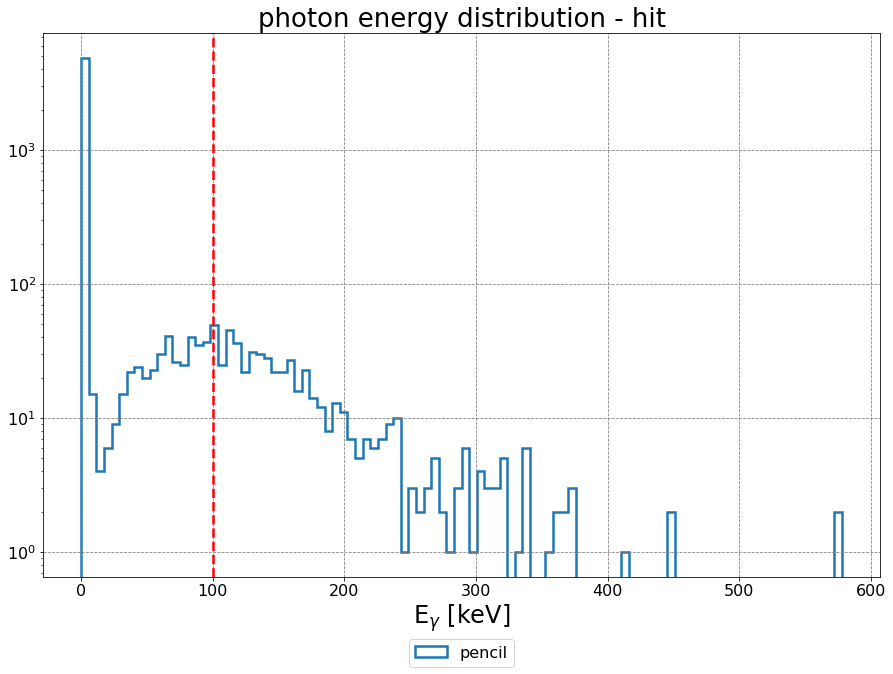

In [15]:
# %lprun -f test.energySpectrum test.energySpectrum( Type = 'hit', zlim=[], legCol=3 )
%time pencil.energySpectrum( Type = 'hit', zlim=[-10,10], legCol = 4, save = 1 )

### 4.2 Hits from Certain Element<a class="anchor" id="HtsElmt"></a>
This method allows to select one (or more) elements and display the hits of $\gamma$s from that (or these) element(s) further upstream on the beam pipe.

collimators fully open.
setting beamType to pencil 
 setting aperture to [] 
 found size 0
data types: beamType = <class 'str'> aperture = <class 'list'> size = <class 'int'>
plotting done, deleted DF.
CPU times: user 9.67 s, sys: 265 ms, total: 9.94 s
Wall time: 9.93 s


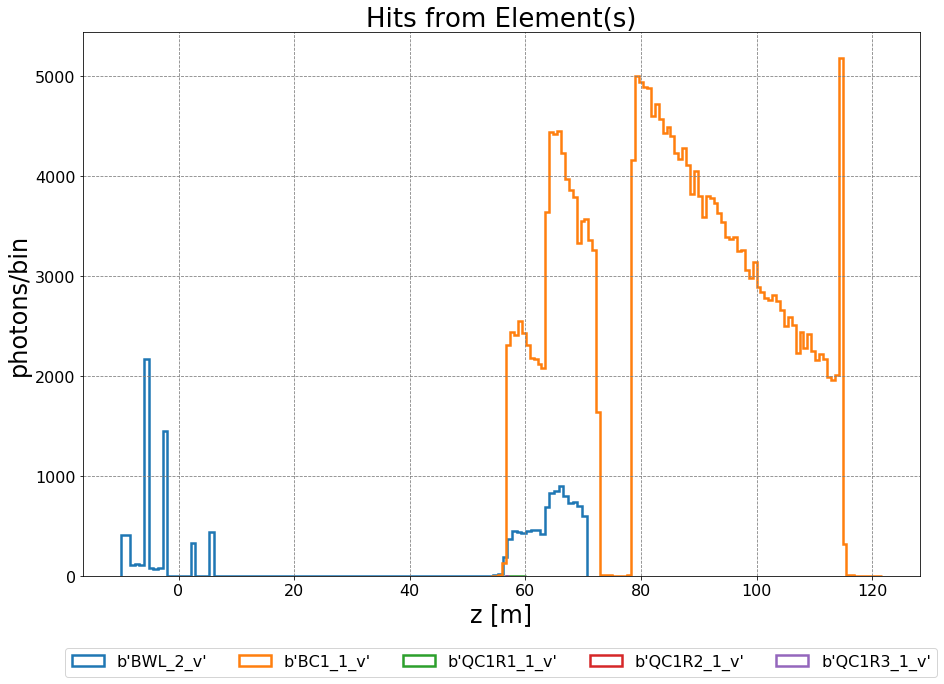

In [29]:
#['BC1_1_v', 'none', 'BC3_1', 'QC5_1', 'QC1R3_1_v', 'BC1_1','QC1R2_1_v', 'BWL_2_v', 'DRIFT_8617', 'DRIFT_8613', 'BC1L_2_v','BWL_2']
# pltdat.plotSrcHits(DFseco_def, plotpath, ['BC1_1_v','BC3_1', 'QC5_1', 'QC1R3_1_v', 'BC1_1','QC1R2_1_v', 'BWL_2_v', 'DRIFT_8617', 'DRIFT_8613', 'BC1L_2_v','BWL_2'], zlim = [], nBin = 100, ticks = 10, save = 0, verbose = 0)        

# , b'SOL2R1_1_v',b'SOL1L1_1_v',b'SOL2L1_1_v'
%time pencil.hitsByElement( elements = [b'BWL_2_v',b'BC1_1_v',b'QC1R1_1_v',b'QC1R2_1_v',b'QC1R3_1_v'], zlim = [-10,200], save = 0 )

## Plot hits of Photons from all Processes
This section uses a tool that should groupby the data on the key 'Creator' to have an overview where $\gamma$s hit from different pocesses. This can help to estimate the local effect of a collimtor.

### 3.1 Available Processes <a class="anchor" id="AvlbPrcs"></a>
Not only synchrotron radiation has to be considered. Once photons impact on the beam pipe, interaction with matter will result in different scattering processes. These processes potentially create other photons which can contribute to the backgrounds, such as the photo effect, pair conversion, Compton and Rayleigh scattering.
The production of additional backgrounds is relevant especially when looking at the leakage of collimators and masks. 

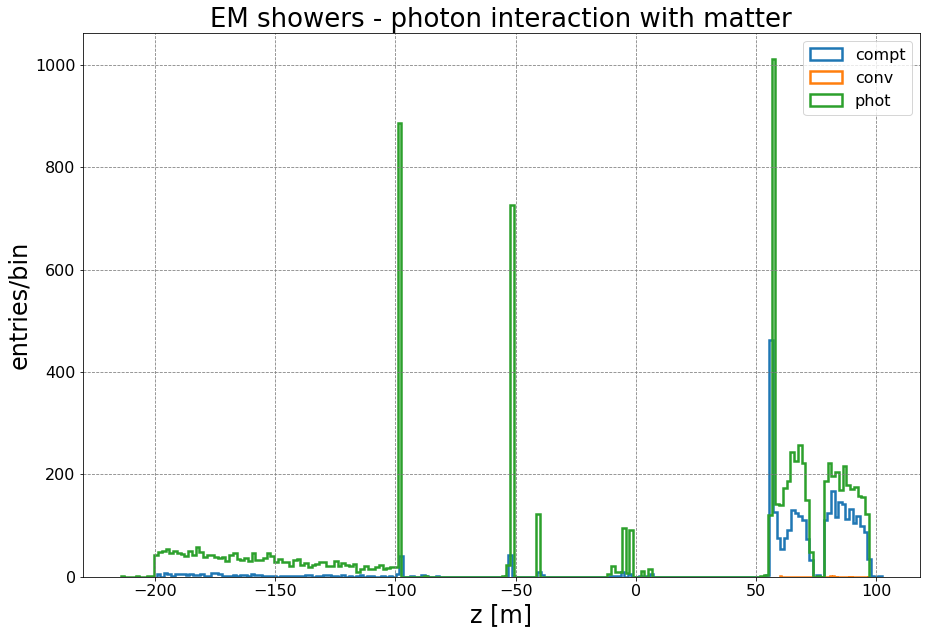

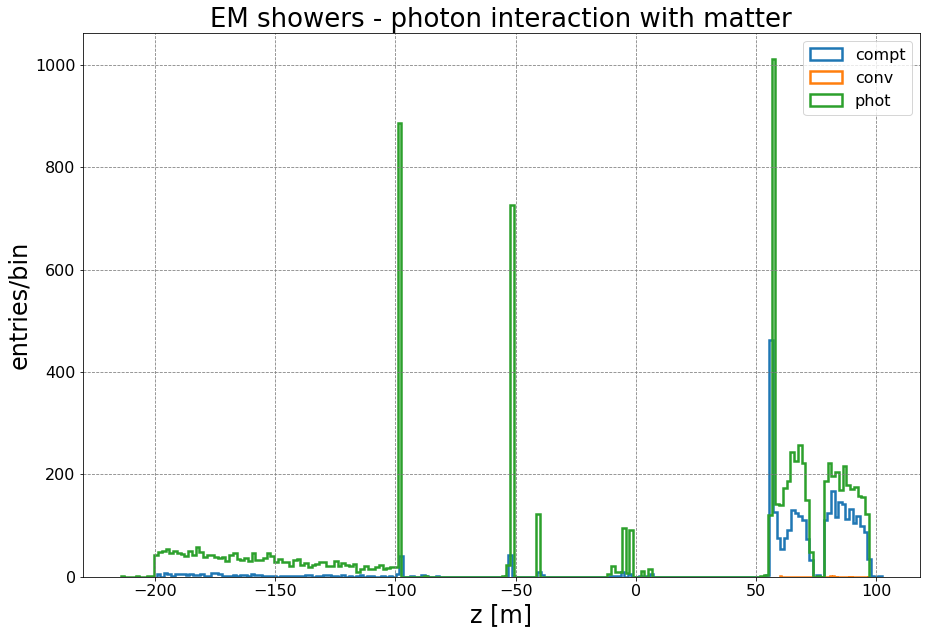

In [15]:
procFrame = Processes(DFseco_def, plotpath, save = 0)
procFrame.prepData()
procFrame.showerDistr()

# Photon Collimation

## Plot the hits of Photons 
Display the hits of photons only originating from the 'Creator' 'SynRad'. It won't show any $\gamma$s generated by other processes

In [5]:
# create the DF's - collimation should be grouped as several cases have to be studied.
#
# pltdat.plot_data(originSR_col, Type = 'hit', save = 1, aperture = [3010])
pltdat.plot_diffApers( pltFCCcol, plotpath, Type = 'hit', aperture = [1535], verbose = 0, zlim = [-20,10], nBin = 12000, ticks = 20, save = 0 )

AttributeError: 'DataFrameGroupBy' object has no attribute 'isini'

## Photon Scoring
Section to analyse the output data from a Geant4 run that is produced within SteppingAction. Photons are registered with their energy and spatial data (Euclidean x,y,z) when they enter a certain volume.

mlu -- 01-26-2018 -- a first trial, feature for TestEm16 still in phase of implementation.

  total number of entries:  2192485  photons.


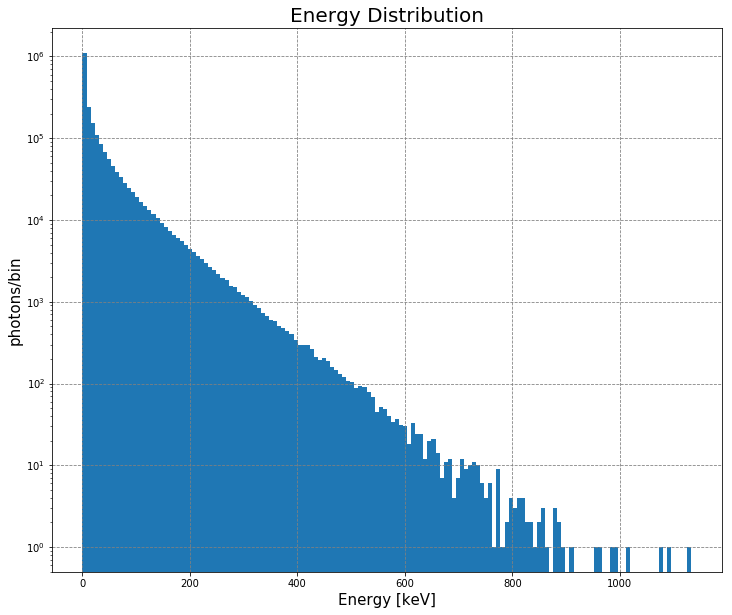

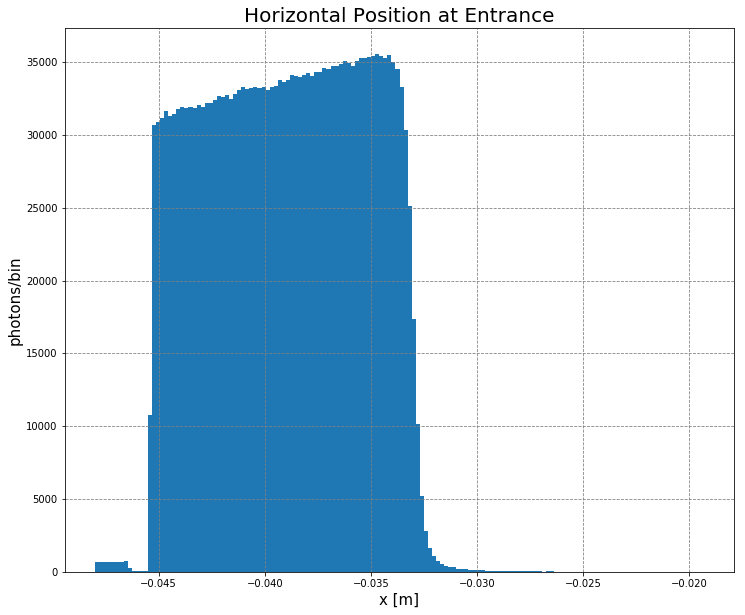

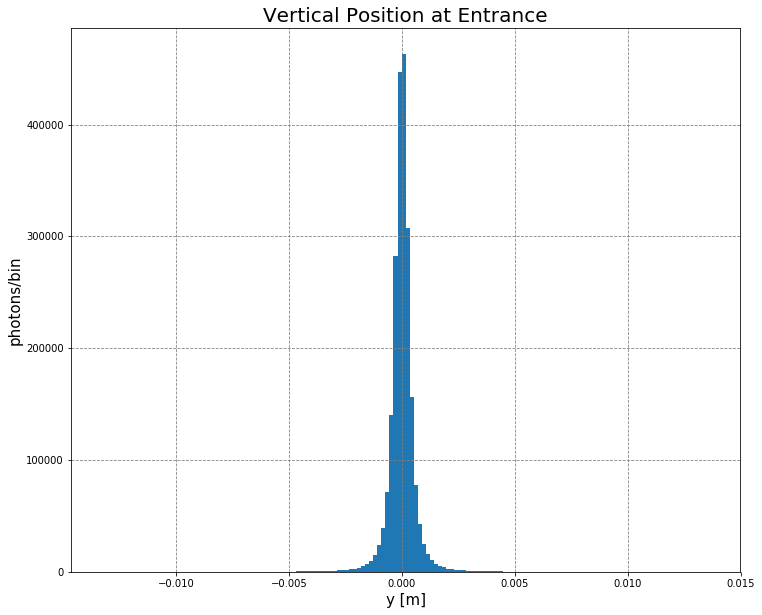

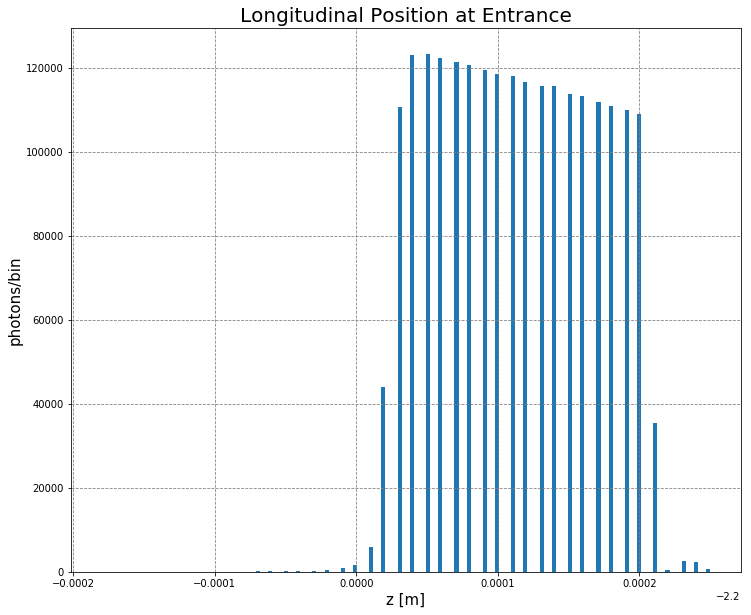

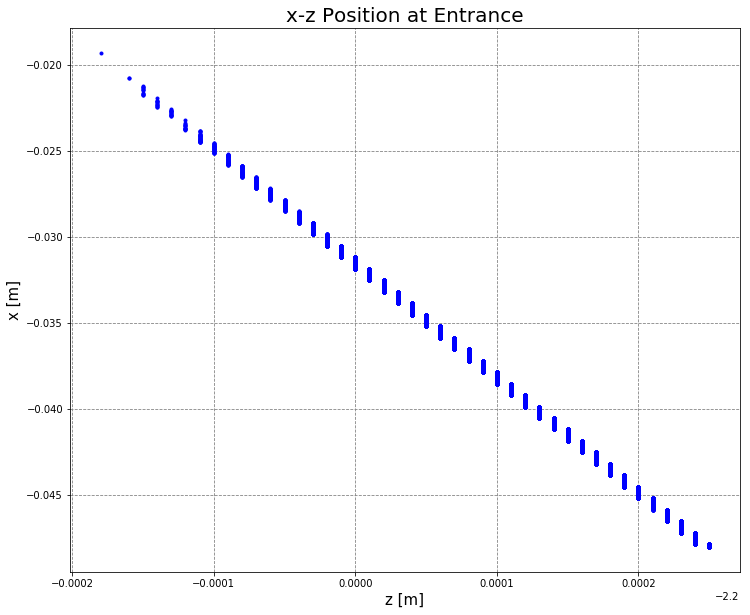

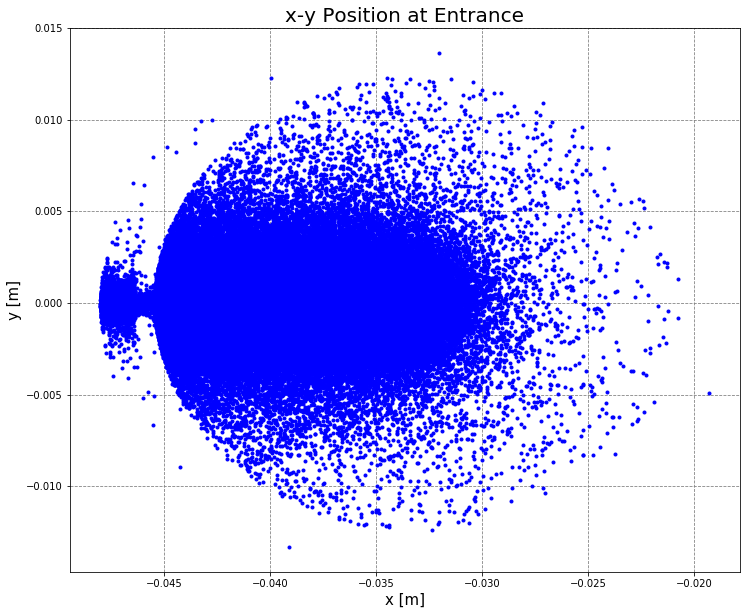

In [23]:
# inputFile = '/home/mlueckhof/Codes/Projects/FCCee/Collimator/Data/tubEn.dat'
inputFile = '/data/Anna/tubEnBWL2_ALL.dat' #'/home/mlueckhof/temporary/tubEnBWL2_ALL.dat'
Plot.plot_spatialGamDistr(inputFile, plotpath, nBin = 150, save = 1) 

### Photons Incident on SR Mask MSK.QC1L1.2

Number of photons incident: 26266


,Element,Energy,x,y,z,px,py,pz
0,BWL_2_v_1,5.297120e+01,-0.040646,-0.000058,-2.19986,0.014939,1.875540e-07,0.999888
1,BWL_2_v_1,5.670540e+01,-0.035433,0.000179,-2.19994,0.014972,1.523630e-06,0.999888
2,BWL_2_v_1,5.896840e+01,-0.033330,-0.000193,-2.19997,0.015000,-5.099890e-07,0.999887
3,BWL_2_v_1,1.073530e-01,-0.043791,-0.000136,-2.19982,0.014895,-1.614130e-06,0.999889
4,BWL_2_v_1,8.896980e+01,-0.038311,0.001297,-2.19990,0.014955,1.159210e-05,0.999888
5,BWL_2_v_1,4.524490e+00,-0.043258,-0.000164,-2.19982,0.014909,-1.962600e-06,0.999889
6,BWL_2_v_1,2.553790e-01,-0.036675,0.000093,-2.19992,0.014977,2.459220e-07,0.999888
7,BWL_2_v_1,6.678620e+00,-0.044071,0.000014,-2.19981,0.014908,-4.282390e-07,0.999889
8,BWL_2_v_1,2.408460e+00,-0.041316,0.000094,-2.19985,0.014918,3.913450e-07,0.999889
9,BWL_2_v_1,8.181570e-07,-0.040055,-0.000142,-2.19987,0.014946,-1.108190e-06,0.999888


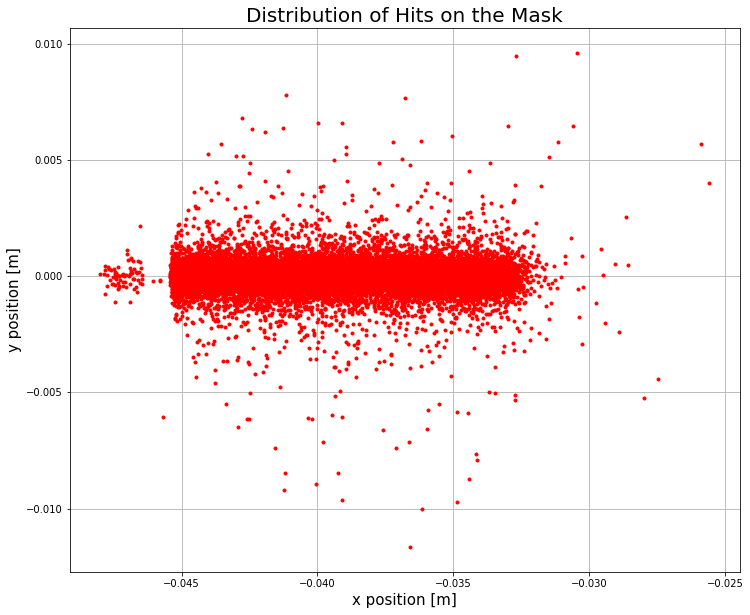

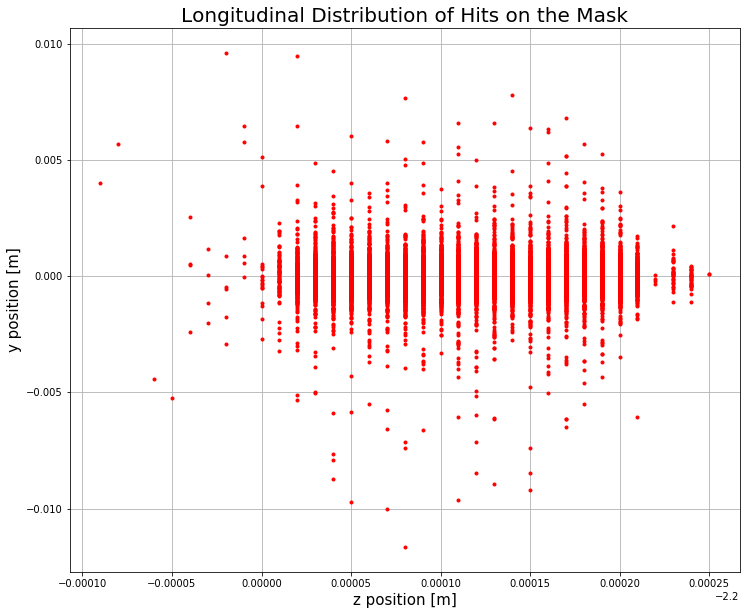

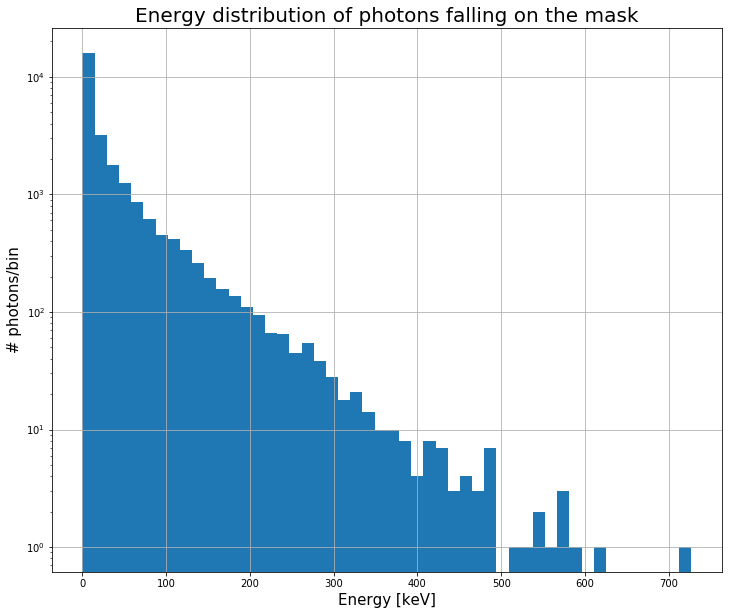

In [10]:
inputFile = '/home/mlueckhof/temporary/tubEnBWL2_ALL.dat'
header = ['Element', 'Energy', 'x', 'y', 'z', 'px', 'py', 'pz']
17	3	DRIFT_8624_v_1	Vacuum	1	DRIFT_8624_1	Cu	1	0.0076643	40.954	-0.0967608	0.0014615	-5.60918	0	0.60908	0.000571491	40.9495	40.954
hitScoreFrame = pd.read_table(inputFile, sep = '\t', header = None, names = header)
hitScoreFrame    

numbPhot = hitScoreFrame.Energy.count()
print ("Number of photons incident:", numbPhot)
# plot the energy distribution
#
plt.figure( figsize = (12,10) )
plt.plot( hitScoreFrame.x.tolist(), 
          hitScoreFrame.y.tolist(), 'r.' )
# plt.yscale('log')
plt.grid()
plt.xlabel( 'x position [m]' )
plt.ylabel( 'y position [m]' )
plt.title( 'Distribution of Hits on the Mask' );
plt.savefig(plotpath + 'hits_on_mask.pdf')

plt.figure( figsize = (12,10) )
plt.plot( hitScoreFrame.z.tolist(), hitScoreFrame.y.tolist(), 'r.' )
plt.grid()
plt.xlabel( 'z position [m]' )
plt.ylabel( 'y position [m]' )
plt.title( 'Longitudinal Distribution of Hits on the Mask' );
# plt.savefig(plotpath + 'hits_on_mask.pdf')

plt.figure( figsize = (12,10) )
plt.hist(hitScoreFrame.Energy, bins = 50 )
plt.xlabel('Energy [keV]'); plt.ylabel('# photons/bin')
plt.yscale('log')
plt.title('Energy distribution of photons falling on the mask')
plt.grid()
hitScoreFrame

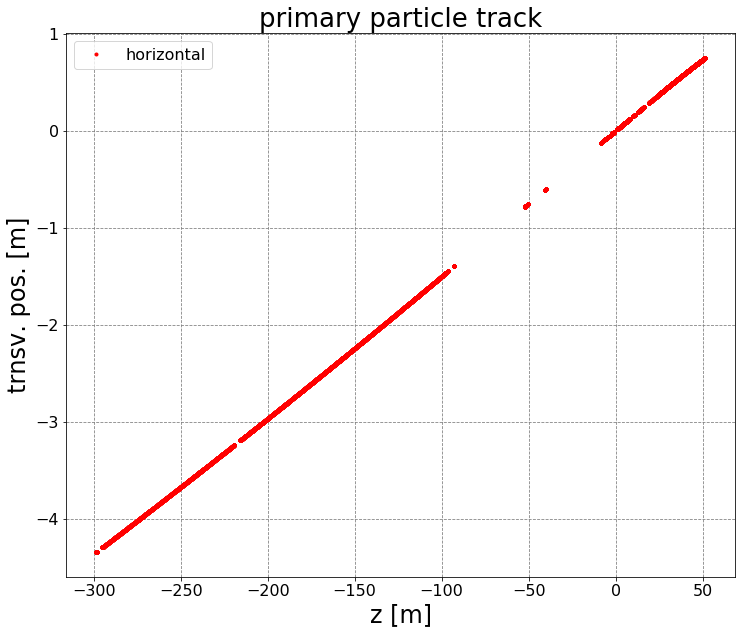

In [10]:
pltdat.plotPrimTrack( DFprim_def, plotpath, axis = 'horizontal' )